##Library

In [ ]:
import os,sys
import zipfile
import random
import shutil

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import PIL
import sklearn
import tensorflow as tf

from tensorflow import keras
from shutil import copyfile
from google.colab import files, drive
from keras.callbacks import ModelCheckpoint
from sklearn.datasets import load_files
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Data Preparation

In [ ]:
!mkdir download
!gdown --id 1KN8bVWE4cU4D1-bZ9YwdNyCswDgwOSuF -O "./download/Akbar.zip"
!gdown --id 10By5X5b04EED4U9tC8g1wF5Q0ndEuZWQ -O "./download/Yusuf.zip"
!gdown --id 1GDMpDDD9xl9BLOa65I_sIlmzCG5mYRYM -O "./download/Deas.zip"

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KN8bVWE4cU4D1-bZ9YwdNyCswDgwOSuF
To: /content/download/Akbar.zip
100% 38.3M/38.3M [00:00<00:00, 78.0MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10By5X5b04EED4U9tC8g1wF5Q0ndEuZWQ
To: /content/download/Yusuf.zip
100% 137M/137M [00:02<00:00, 63.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.g

In [ ]:
for item in os.listdir('./download/'):
  zip_ref = zipfile.ZipFile('./download/'+item, 'r')
  zip_ref.extractall('./Dataset')
  zip_ref.close()

jenis_buah=os.listdir('./Dataset/')
jenis_buah.sort()
print(jenis_buah)
num_class=len(jenis_buah)

['Apple', 'Avocado', 'Banana', 'Grape', 'Guava', 'Mango', 'Melon', 'Orange', 'Papaya', 'Pear', 'Strawberry', 'Watermelon']


## Data Extraction

In [ ]:
batch_size = 32
img_height = 100
img_width = 100
data_dir="./Dataset"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28737 files belonging to 12 classes.
Using 22990 files for training.
Found 28737 files belonging to 12 classes.
Using 5747 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'Avocado', 'Banana', 'Grape', 'Guava', 'Mango', 'Melon', 'Orange', 'Papaya', 'Pear', 'Strawberry', 'Watermelon']


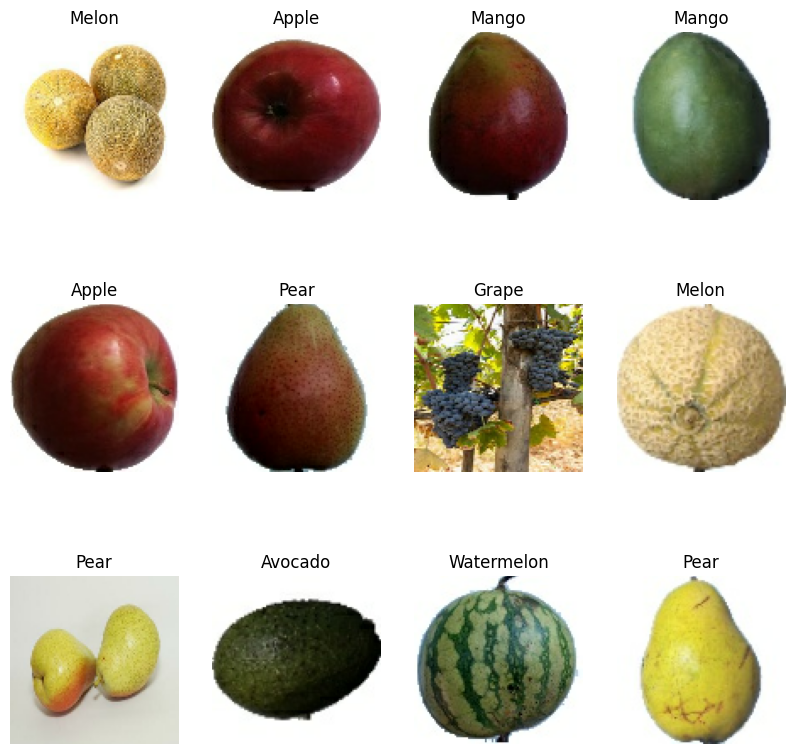

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


## Data Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical",
                             input_shape=(img_height,img_width,3)),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomBrightness(0.1)
])

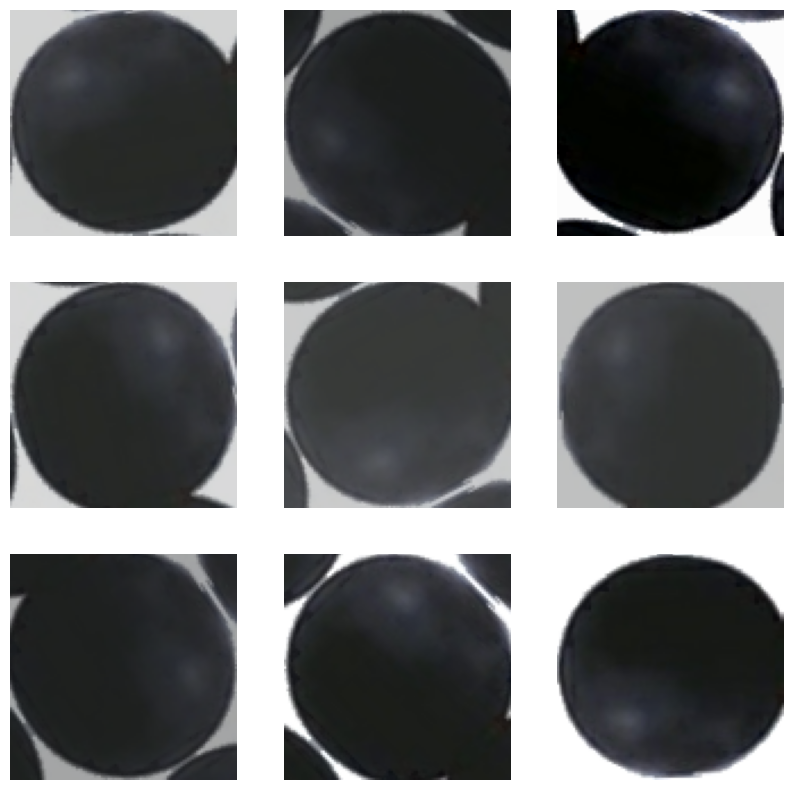

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train Model

In [ ]:
model = tf.keras.Sequential([data_augmentation])

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-09 03:05:51--  https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889256 (56M) [application/octet-stream]
Saving to: ‘/tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/vgg16_weights_ 100%[===================>]  56.16M   179MB/s    in 0.3s    

2023-06-09 03:05:51 (179 MB/s) - ‘/tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [58889256/58889256]



In [ ]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = tf.keras.applications.vgg16.VGG16(input_shape = (img_height, img_width, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 14,714,688 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
# output_of_last_layer
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('block5_pool')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 3, 3, 512)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
# create_final_model
def create_final_model(pre_trained_model, last_output):

  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(12, activation = 'softmax')(x)

  # Create the complete model by using the Model class
  model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = 'adam',
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics = ['accuracy'])

  return model

In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 19,446,604 total parameters in this model.
There are 4,731,916 trainable parameters in this model.


In [ ]:
EPOCHS = 15
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs = EPOCHS,
                    verbose = 1
)

Epoch 1/15
719/719 [==============================] - 47s 51ms/step - loss: 1.6945 - accuracy: 0.9333 - val_loss: 0.3930 - val_accuracy: 0.9725
Epoch 2/15
719/719 [==============================] - 32s 44ms/step - loss: 0.3913 - accuracy: 0.9720 - val_loss: 0.3895 - val_accuracy: 0.9763
Epoch 3/15
719/719 [==============================] - 36s 50ms/step - loss: 0.3660 - accuracy: 0.9779 - val_loss: 0.5707 - val_accuracy: 0.9711
Epoch 4/15
719/719 [==============================] - 32s 45ms/step - loss: 0.4035 - accuracy: 0.9805 - val_loss: 1.3615 - val_accuracy: 0.9591
Epoch 5/15
719/719 [==============================] - 32s 44ms/step - loss: 0.4182 - accuracy: 0.9836 - val_loss: 0.5261 - val_accuracy: 0.9807
Epoch 6/15
719/719 [==============================] - 33s 45ms/step - loss: 0.2850 - accuracy: 0.9873 - val_loss: 0.7992 - val_accuracy: 0.9729
Epoch 7/15
719/719 [==============================] - 32s 44ms/step - loss: 0.3683 - accuracy: 0.9875 - val_loss: 0.6291 - val_accuracy:

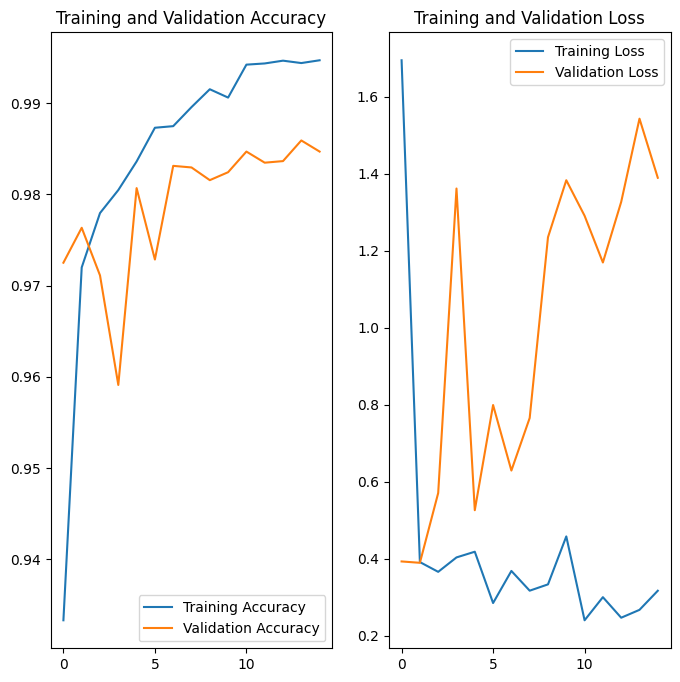

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

##Predicting

In [ ]:
uploaded = files.upload()

for path in uploaded.keys():
  img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  print(predictions[0])
  #score = tf.nn.softmax(predictions[0])
  score = predictions[0]

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  for i,j in sorted(zip(100*score, class_names), reverse=True)[:3]:
    print("{} : {:.2f}% confidence".format(j, i))

Saving avocado.jpg to avocado.jpg
1/1 [==============================] - 1s 585ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This image most likely belongs to Avocado with a 100.00 percent confidence.
Avocado : 100.00% confidence
Watermelon : 0.00% confidence
Strawberry : 0.00% confidence


# Convert Model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model.save('model.h5')

In [ ]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>